Imports for the code below

In [1]:
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
import random

Constants used for rotating the rubik cube as well as rendering the 2D laid out cube

In [2]:
MOVES = np.array([
    [0, 21, 2, 23, 6, 4, 7, 5, 19, 9, 17, 11, 12, 13, 14, 15, 16, 1, 18, 3, 20, 10, 22, 8], # R
    [0, 1, 14, 15, 4, 5, 2, 3, 8, 9, 6, 7, 12, 13, 10, 11, 16, 17, 18, 19, 22, 20, 23, 21], # F
    [2, 0, 3, 1, 18, 5, 19, 7, 8, 9, 10, 11, 12, 20, 14, 21, 16, 17, 15, 13, 6, 4, 22, 23], # U
    [0, 17, 2, 19, 5, 7, 4, 6, 23, 9, 21, 11, 12, 13, 14, 15, 16, 10, 18, 8, 20, 1, 22, 3], # R'
    [0, 1, 6, 7, 4, 5, 10, 11, 8, 9, 14, 15, 12, 13, 2, 3, 16, 17, 18, 19, 21, 23, 20, 22], # F'
    [1, 3, 0, 2, 21, 5, 20, 7, 8, 9, 10, 11, 12, 19, 14, 18, 16, 17, 4, 6, 13, 15, 22, 23], # U'
])

COLORS = {
    0: "#003DA5",  # blue
    1: "#BA0C2F",  # red
    2: "#009B48",  # green
    3: "#FE5000",  # orange
    4: "#FFD700",  # yellow
    5: "#FFFFFF",  # white
}

In [3]:
class Move(Enum):
    R = 0
    F = 1
    U = 2
    Rp = 3
    Fp = 4
    Up = 5

class Cube:
    def __init__(self):
        self.goal_state = np.repeat(np.arange(6), 4)
        self.state = np.repeat(np.arange(6), 4)
            
    def __lt__(self, other):
        if not isinstance(other, Cube):
            raise ValueError
        return self.state < other.state
    
    def __eq__(self, other):
        if not isinstance(other, Cube):
            raise False
        return np.all(self.state == other.state)
    
    def __hash__(self) -> int:
        return hash(tuple(self.state))

    def move(self, moves: list[Move]) -> 'Cube':
        for move in moves:
            self.state = self.state[MOVES[move.value]]

    def clone(self) -> 'Cube':
        cube = Cube()
        cube.state = np.copy(self.state)
        return cube

    def hash(self) -> str:
        return ''.join(map(str, self.state))

    def scramble(self, n: int = 30) -> None:
        moves = [random.choice(list(Move)) for _ in range(n)]
        self.move(moves)

    def render(self):
        _, ax = plt.subplots(figsize=(7, 5))
        base_coords = np.array([(0, 1), (1, 1), (0, 0), (1, 0)])
        offsets = np.array([[0, 0], [1, 0], [2, 0], [-1, 0], [0, 1], [0, -1]]) * 2

        idx = 0

        for offset in offsets:
            for coords in base_coords:
                rect = plt.Rectangle(coords + offset, 1, 1, edgecolor='black', linewidth=1)
                rect.set_facecolor(COLORS[self.state[idx]])
                ax.add_patch(rect)
                idx += 1

        ax.set_xlim(-2.1, 6.1)
        ax.set_ylim(-2.1, 4.1)
        ax.axis('off')
        plt.show()

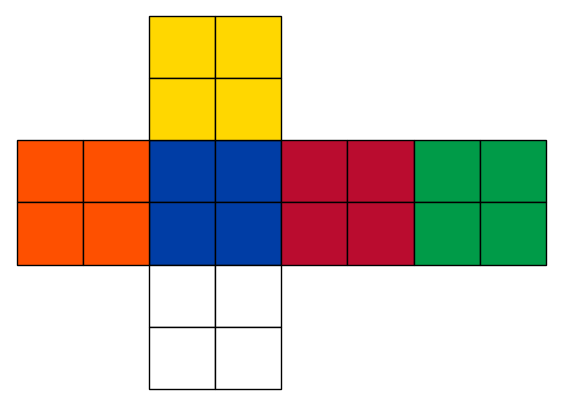

In [4]:
cube = Cube()
cube.render()

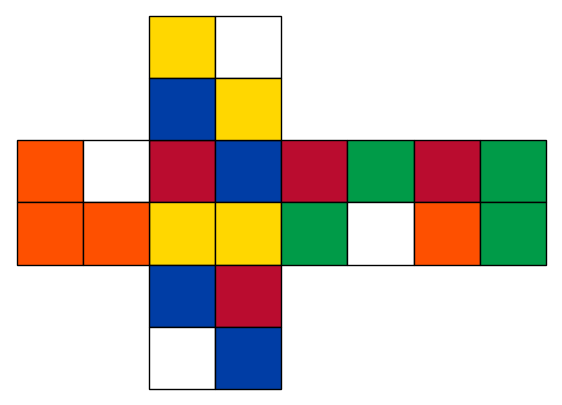

In [5]:
cube = Cube()
cube.scramble()
cube.render()

#### A* algorithm

In [6]:
from heapq import heappush, heappop
from typing import Callable, Iterable

class astar_Node:
    def __init__(self, f: float, state: object) -> None:
        self.f = f
        self.state = state
    
    def __eq__(self, __value: object) -> bool:
        return self.state == __value.state
    
    def __lt__(self, __value: object) -> bool:
        return self.f < __value.f

def a_star(start: object, goal: object, next_states: Callable[[object], Iterable[object]], 
           h: Callable[[object], float], g: Callable[[object, object], float]) -> tuple[float, float]:
    """
    Computes the optimal sistance from start to goal
    Args:
        start (object): the start of the search, the first state
        goal (object): the state we want to find the shortest path to
        next_states (Callable[[object], Iterable[object]]): function that creates a list of possible next states from a goven one
        h (Callable[[object], float]): heuristic function that approximates the remaining cost froma  given state to the goal
        g (Callable[[object, object], float]): fucntion taht return the cost for going between two states

    Returns:
        tuple[float, float]: (solution lenght, number of states visited in total by the A* algorithm)
    """
    heap: list[astar_Node] = []
    heappush(heap, astar_Node(h(start), start))
    
    cost: dict[object, float] = {}
    cost[start] = 0
    
    parent: dict[object, object] = {start: None}
    
    while heap:
        node = heappop(heap)
        
        if node.state == goal:
            solution = []
            while node.state is not None:
                solution.append(node.state)
                node.state = parent[node.state]
            return (reversed(solution), len(cost))
        
        for next_state in next_states(node.state):
            aux = cost[node.state] + g(node.state, next_state)
            if aux < cost.get(next_state, float('inf')):
                cost[next_state] = aux
                parent[next_state] = node.state
                heappush(heap, astar_Node(aux + h(next_state), next_state))
                
    return (None, len(cost))

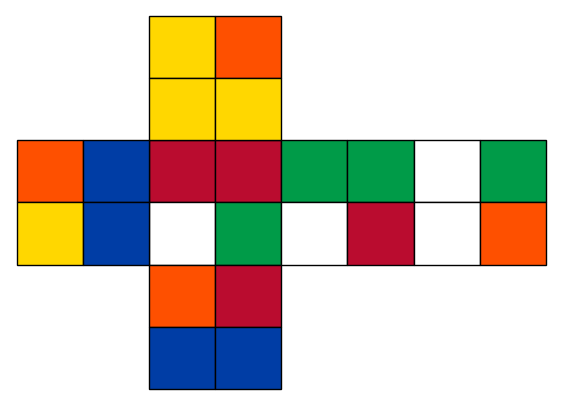

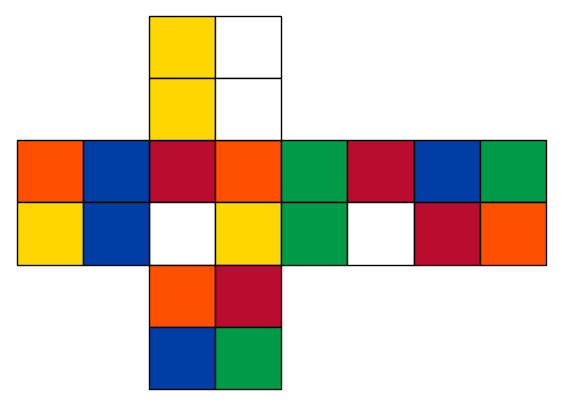

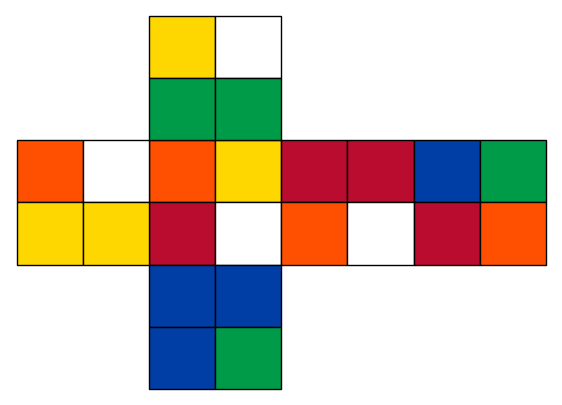

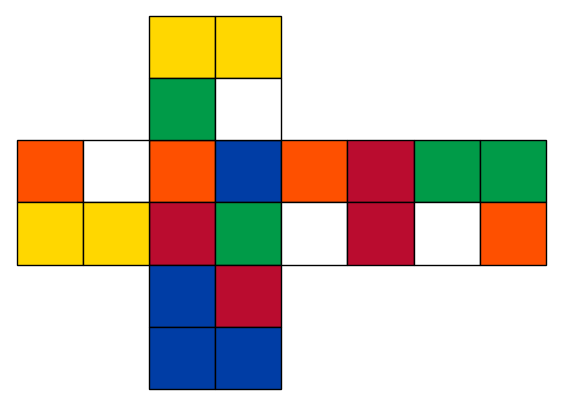

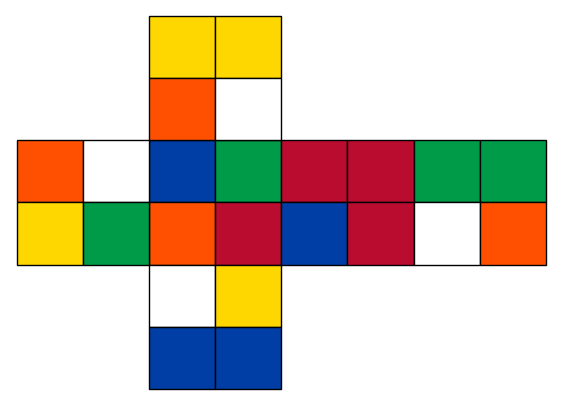

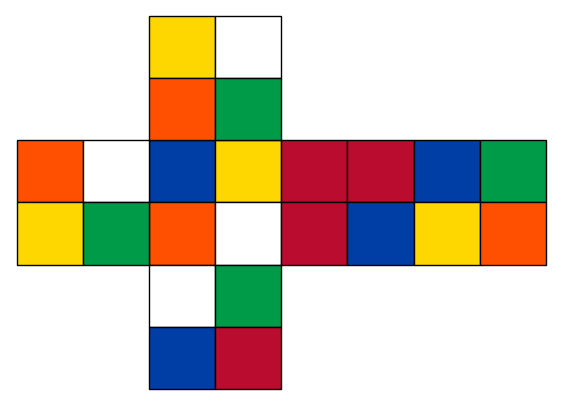

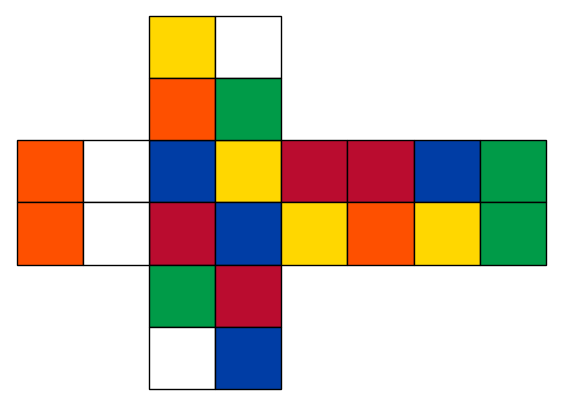

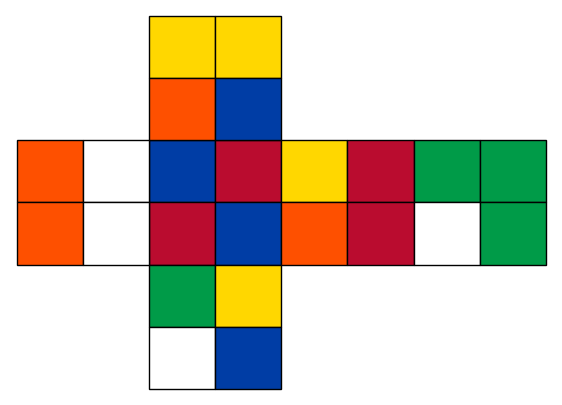

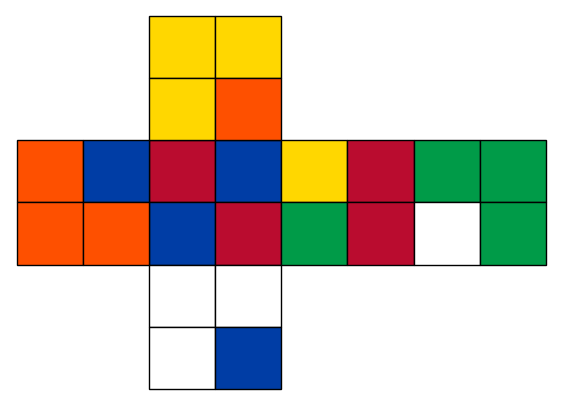

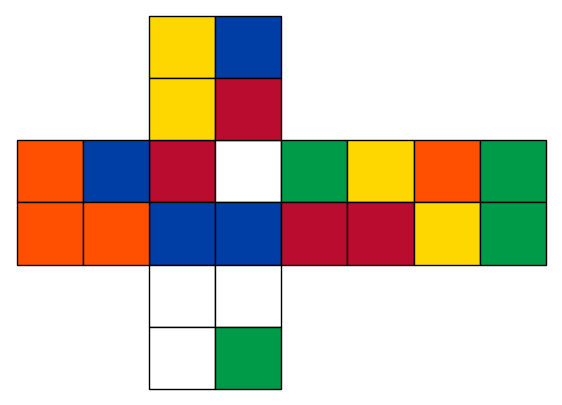

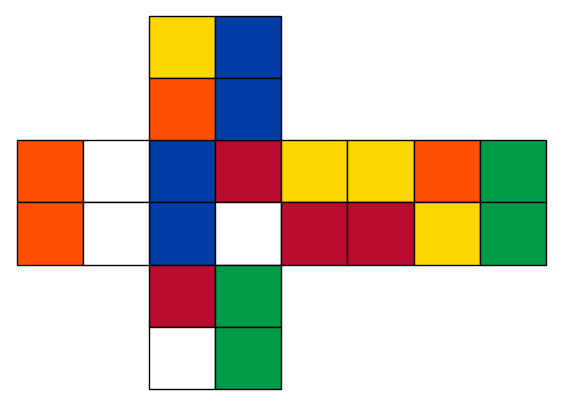

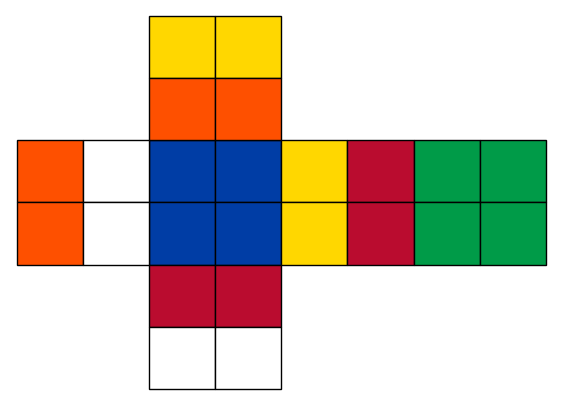

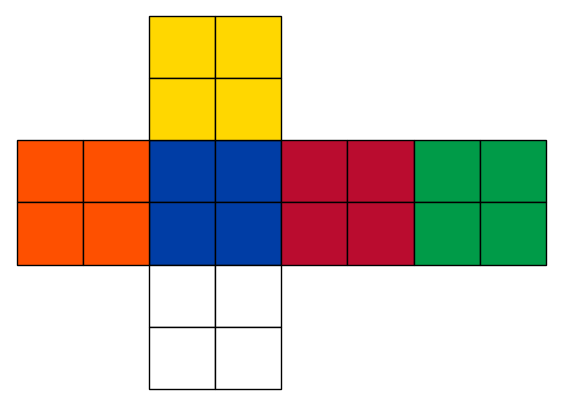

In [7]:
cube = Cube()
cube.scramble()

goal = Cube()

def next_states(cube: Cube) -> Iterable[Cube]:
    for move in Move:
        new_cube = cube.clone()
        new_cube.move([move])
        yield new_cube
        
def h(cube: Cube) -> float:
    return np.sum(cube.state != cube.goal_state)

def g(cube1: Cube, cube2: Cube) -> float:
    if cube1 == cube2:
        return 0
    return 1

solution, _ = a_star(cube, goal, next_states, h, g)
for state in solution:
    state.render()